In [1]:
import numpy as np
import pandas as pd
import tqdm

In [2]:
data_dir = '/home/vadim/playlist_generation/data/random_data'

### Загружаем mpd_data(Million playlist dataset)

In [3]:
mpd_data = pd.read_csv('{}/transactions.csv'.format(data_dir), index_col=0)
mpd_data.head()

,pid,trackid
2429,822032,2283
2434,822032,2288
2435,822032,907
2436,822032,2289
2437,822032,910


### Определяем рейтинг единичкой

In [4]:
mpd_data['rating'] = 1
mpd_data.head()

,pid,trackid,rating
2429,822032,2283,1
2434,822032,2288,1
2435,822032,907,1
2436,822032,2289,1
2437,822032,910,1


### Обрежем mpd_data по пользователям для быстроты

In [5]:
data = mpd_data

In [6]:
data.shape

(210950, 3)

In [7]:
from polara.recommender.data import RecommenderData
from polara.recommender.models import SVDModel
from sklearn.model_selection import KFold

In [8]:
def cross_validation_svd(data, n_splits=5, seed=1, test_size=0.05, topk=500, rank=10):
    kf = KFold(n_splits=n_splits, random_state=seed)
    i = 1
    scores = {'precision': [], 'recall': [], 'miss_rate': [], 'nDCG': []}
    for users_ids, unseen_users_ids in kf.split(data['pid'].drop_duplicates()):
        print('=========================Fold {}============================='.format(i))
        i += 1
        users = data['pid'].drop_duplicates().values[users_ids]
        unseen_users = data['pid'].drop_duplicates().values[unseen_users_ids]
        train = data.query('pid in @users')
        test = data.query('pid in @unseen_users')
        test_sampled = test.sample(frac=1-test_size, random_state=seed).sort_values('pid')
        test_holdout = test[~test.index.isin(test_sampled.index)]
        
        data_model = RecommenderData(train,'pid', 'trackid', 'rating', seed=seed)
        data_model.prepare_training_only()
        svd = SVDModel(data_model)
        svd.rank = rank
        svd.build()
        
        data_model.set_test_data(testset=test_sampled, holdout=test_holdout, warm_start=True)
        svd.switch_positive = 1
        svd.topk = topk
        relevance = svd.evaluate('relevance')
        ranking = svd.evaluate('ranking')
        
        scores['precision'].append(relevance.precision)
        scores['recall'].append(relevance.recall)
        scores['miss_rate'].append(relevance.miss_rate)
        scores['nDCG'].append(ranking.nDCG)
        
    result = pd.DataFrame(scores)
    return result

In [9]:
topks = [500]
ranks = [3,4,5,10, 25, 50]
recall = []
nDCG = []
precision = []
miss_rate = []
for rank in tqdm.tqdm(ranks):
    print('             ===========rank={}============='.format(rank))
    print(data.shape)
    result = cross_validation_svd(data, topk=500, test_size=0.1, rank=rank)
    recall.append(result.recall.mean())
    nDCG.append(result.nDCG.mean())
    precision.append(result.precision.mean())
    miss_rate.append(result.miss_rate.mean())

  0%|          | 0/6 [00:00<?, ?it/s]

             ===========rank=3=============
(210950, 3)
=========================Fold 1=============================
Preparing data...
Done.
PureSVD training time: 0.1245972660001371s
612 unique trackid's within 669 testset interactions were filtered. Reason: not in the training data.
79 unique trackid's within 79 holdout interactions were filtered. Reason: not in the training data.
316 pid's were filtered out from testset. Reason: inconsistent with holdout.
=========================Fold 2=============================
Preparing data...
Done.
PureSVD training time: 0.05795301900002414s
608 unique trackid's within 658 testset interactions were filtered. Reason: not in the training data.
70 unique trackid's within 70 holdout interactions were filtered. Reason: not in the training data.
329 pid's were filtered out from testset. Reason: inconsistent with holdout.
=========================Fold 3=============================
Preparing data...
Done.
PureSVD training time: 0.057301035999898886s

 17%|█▋        | 1/6 [00:03<00:18,  3.75s/it]

             ===========rank=4=============
(210950, 3)
=========================Fold 1=============================
Preparing data...
Done.
PureSVD training time: 0.1156905520001601s
612 unique trackid's within 669 testset interactions were filtered. Reason: not in the training data.
79 unique trackid's within 79 holdout interactions were filtered. Reason: not in the training data.
316 pid's were filtered out from testset. Reason: inconsistent with holdout.
=========================Fold 2=============================
Preparing data...
Done.
PureSVD training time: 0.1200182949999089s
608 unique trackid's within 658 testset interactions were filtered. Reason: not in the training data.
70 unique trackid's within 70 holdout interactions were filtered. Reason: not in the training data.
329 pid's were filtered out from testset. Reason: inconsistent with holdout.
=========================Fold 3=============================
Preparing data...
Done.
PureSVD training time: 0.05731122199995298s
5

 33%|███▎      | 2/6 [00:07<00:15,  3.78s/it]

             ===========rank=5=============
(210950, 3)
=========================Fold 1=============================
Preparing data...
Done.
PureSVD training time: 0.16235727899993435s
612 unique trackid's within 669 testset interactions were filtered. Reason: not in the training data.
79 unique trackid's within 79 holdout interactions were filtered. Reason: not in the training data.
316 pid's were filtered out from testset. Reason: inconsistent with holdout.
=========================Fold 2=============================
Preparing data...
Done.
PureSVD training time: 0.0641946809998899s
608 unique trackid's within 658 testset interactions were filtered. Reason: not in the training data.
70 unique trackid's within 70 holdout interactions were filtered. Reason: not in the training data.
329 pid's were filtered out from testset. Reason: inconsistent with holdout.
=========================Fold 3=============================
Preparing data...
Done.
PureSVD training time: 0.15189147900014177s


 50%|█████     | 3/6 [00:12<00:12,  4.01s/it]

             ===========rank=10=============
(210950, 3)
=========================Fold 1=============================
Preparing data...
Done.
PureSVD training time: 0.0988031320000573s
612 unique trackid's within 669 testset interactions were filtered. Reason: not in the training data.
79 unique trackid's within 79 holdout interactions were filtered. Reason: not in the training data.
316 pid's were filtered out from testset. Reason: inconsistent with holdout.
=========================Fold 2=============================
Preparing data...
Done.
PureSVD training time: 0.12158386999999493s
608 unique trackid's within 658 testset interactions were filtered. Reason: not in the training data.
70 unique trackid's within 70 holdout interactions were filtered. Reason: not in the training data.
329 pid's were filtered out from testset. Reason: inconsistent with holdout.
=========================Fold 3=============================
Preparing data...
Done.
PureSVD training time: 0.20581737099996644s

 67%|██████▋   | 4/6 [00:16<00:08,  4.02s/it]

             ===========rank=25=============
(210950, 3)
=========================Fold 1=============================
Preparing data...
Done.
PureSVD training time: 0.23499023399995167s
612 unique trackid's within 669 testset interactions were filtered. Reason: not in the training data.
79 unique trackid's within 79 holdout interactions were filtered. Reason: not in the training data.
316 pid's were filtered out from testset. Reason: inconsistent with holdout.
=========================Fold 2=============================
Preparing data...
Done.
PureSVD training time: 0.2984180110001944s
608 unique trackid's within 658 testset interactions were filtered. Reason: not in the training data.
70 unique trackid's within 70 holdout interactions were filtered. Reason: not in the training data.
329 pid's were filtered out from testset. Reason: inconsistent with holdout.
=========================Fold 3=============================
Preparing data...
Done.
PureSVD training time: 0.27224408799997946s

 83%|████████▎ | 5/6 [00:21<00:04,  4.24s/it]

             ===========rank=50=============
(210950, 3)
=========================Fold 1=============================
Preparing data...
Done.
PureSVD training time: 0.706825740000113s
612 unique trackid's within 669 testset interactions were filtered. Reason: not in the training data.
79 unique trackid's within 79 holdout interactions were filtered. Reason: not in the training data.
316 pid's were filtered out from testset. Reason: inconsistent with holdout.
=========================Fold 2=============================
Preparing data...
Done.
PureSVD training time: 0.6765222519998133s
608 unique trackid's within 658 testset interactions were filtered. Reason: not in the training data.
70 unique trackid's within 70 holdout interactions were filtered. Reason: not in the training data.
329 pid's were filtered out from testset. Reason: inconsistent with holdout.
=========================Fold 3=============================
Preparing data...
Done.
PureSVD training time: 1.0002173309999307s
58

100%|██████████| 6/6 [00:28<00:00,  4.74s/it]


In [10]:
import matplotlib.pyplot as plt

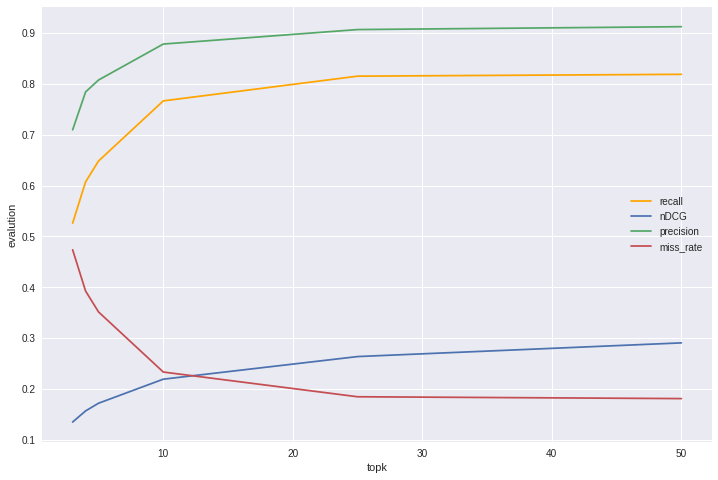

In [11]:
plt.style.use('seaborn')
plt.figure(figsize=(12,8))
plt.plot(ranks, recall, 'orange', label='recall')
plt.plot(ranks, nDCG,label='nDCG')
plt.plot(ranks, precision, label='precision')
plt.plot(ranks, miss_rate, label='miss_rate')
plt.ylabel('evalution')
plt.xlabel('topk')
plt.legend()
plt.show()